In [15]:
import numpy as np

import torch

from torch.utils.data import DataLoader

from models.gan_camel import Discriminator, Generator

from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
real_images = np.load("../data/camel/full_numpy_bitmap_camel.npy").reshape((-1, 1, 28, 28)).astype(np.float32) / 255
plt.imshow(real_images[0][0], cmap='gray')
plt.show()

<IPython.core.display.Javascript object>

In [5]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
adversarial_loss = torch.nn.BCELoss().cuda()

optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=2e-4)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=2e-4)

In [6]:
N_EPOCHS = 10
BATCH_SIZE = 64
N_CRITIC_UPDATES = 5

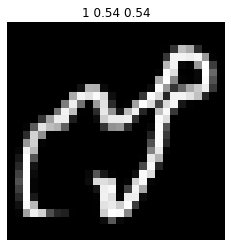

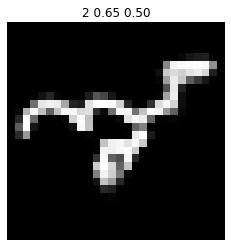

KeyboardInterrupt: 

In [21]:
image_loader = DataLoader(real_images, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

g_losses = []
real_losses = []
fake_losses = []

for epoch in range(N_EPOCHS):
    t = tqdm(image_loader, desc=f"Epoch {epoch}. g_loss {0.0:.2f} d_loss {0.0:.2f}")
    for i, real_imgs in enumerate(t):

        generator.train()
        discriminator.eval()

        valid = torch.ones(BATCH_SIZE, 1)
        fake = torch.zeros(BATCH_SIZE, 1)

        # train generator
        optimizer_G.zero_grad()

        z = torch.randn(BATCH_SIZE, 100, requires_grad=True)

        gen_imgs = generator(z.cuda())

        g_loss = adversarial_loss(discriminator(gen_imgs), valid.cuda())
        g_losses.append(g_loss.item())

        g_loss.backward()
        optimizer_G.step()

        # train discriminator
        discriminator.train()
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs.cuda()), valid.cuda())
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake.cuda())
        real_losses.append(real_loss.item())
        fake_losses.append(fake_loss.item())
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            t.set_description(f"Epoch {epoch}. g_loss {g_loss.item():.2f} d_loss {d_loss.item():.2f}")

    plt.figure()
    plt.title(f"{epoch+1} {g_loss.item():.2f} {d_loss.item():.2f}")
    plt.axis("off")
    generator.eval()
    plt.imshow(generator(torch.randn(1, 100).cuda()).cpu().detach().squeeze(), cmap='gray')
    plt.show()

    torch.save(generator.state_dict(), "models/generator_camel.pt")
    torch.save(discriminator.state_dict(), "models/discriminator_camel.pt")

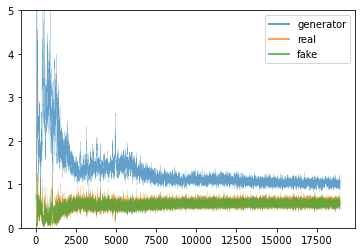

In [21]:
plt.plot(g_losses, label='generator', alpha=0.7, linewidth=0.2)
plt.plot(real_losses, label='real', alpha=0.7, linewidth=0.2)
plt.plot(fake_losses, label='fake', alpha=0.7, linewidth=0.2)
leg = plt.legend()
for i in range(3):
    leg.get_lines()[i].set_linewidth(2)
plt.ylim(0, 5)
plt.show()